*A notebook on a shrinkage correction approach where we just run PCA holding 1 single sample at a time for every sample ...*

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import pandas as pd
import pcshrink

# Data prep

In [4]:
%%time
data = pcshrink.UnpackedAncestryMap("/project/jnovembre/jhmarcus/ancient-sardinia/data/ref_genotypes/7-11-2018/lazaridis_2014/data_fil")

CPU times: user 6.92 s, sys: 2.25 s, total: 9.17 s
Wall time: 3.58 s


In [5]:
print(data.n, data.p)

777 594924


Find snps that are too rare or too common

In [6]:
# use allele frequency estimator from Price et al. 2006
f = (1. + np.nansum(data.Y, axis=1)) / (2 + (2. * data.n))

# keep snps that aren't too rare or common
snp_idx = np.where((f > .02) & (f < .98))[0]
print(f.shape, snp_idx.shape)

(594924,) (426765,)


Mean center and scale and impute missing values to 0

In [7]:
Z = data.Y[snp_idx, :]

# mean genotype 
mu = np.nanmean(Z, axis=1).reshape(len(snp_idx), 1)

# empirical std deviation
std = np.nanstd(Z, axis=1).reshape(len(snp_idx), 1)

# heterozygosity scaler
het = np.sqrt(2. * f[snp_idx] * (1. - f[snp_idx])).reshape(len(snp_idx), 1)

Z = (Z - mu) / het
Z[np.isnan(Z)] = 0.0

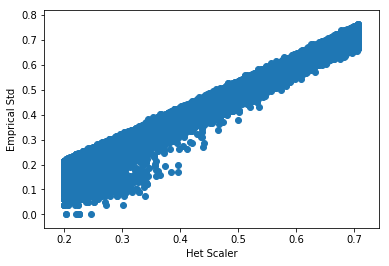

In [8]:
plt.scatter(het, std);
plt.xlabel("Het Scaler");
plt.ylabel("Emprical Std");

# PCA

In [9]:
%%time
k = 10
cor = pcshrink.ShrinkageCorrector(Z, k)

CPU times: user 1min 22s, sys: 4.91 s, total: 1min 27s
Wall time: 3.57 s


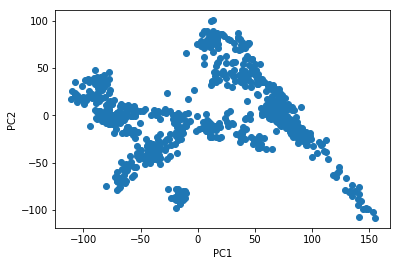

In [11]:
plt.scatter(cor.L[:,0], -cor.L[:,1])
plt.xlabel("PC1");
plt.ylabel("PC2");

In [14]:
%%time
L_shrunk = cor.jackknife(k=10, o=2, s=10)

holding out sample 0
holding out sample 2
holding out sample 4
holding out sample 6
holding out sample 8
CPU times: user 19min 59s, sys: 46.1 s, total: 20min 45s
Wall time: 1min 15s


(10,)

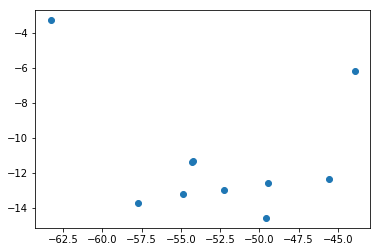

In [18]:
plt.scatter(cor.L_shrunk[:, 0], -cor.L_shrunk[:, 1])
#plt.scatter(pc.L[pc.samp_idx, 0], pc.L_shrunk[:, 0])


In [ ]:
np.sum(pc.L_shrunk, axis=0).shape

In [ ]:
#plt.scatter(L_shrunk[:, 0], -L_shrunk[:, 1])
plt.scatter(pc.L[:, 0], -pc.L[:, 1])


In [ ]:
plt.figure(figsize=(10, 8))
plt.quiver(L[:,0], 
           -L[:, 1], 
           L_[:, 0] - L[:,0],
           -(L_[:, 1] - L[:, 1]), headwidth=2)

plt.xlabel("PC1");
plt.ylabel("PC2");
plt.ylim()
plt.autoscale()


Plot PC1 vs PC2

In [ ]:
%%time

K = 10
q = data.n
L_proj = np.empty((q, K))

for i in range(q):
    
    print(i)
    
    idx = np.ones(data.n, dtype="bool")
    idx[i] = False
    
    z = Z[:, i]
    Z_train = Z[:, idx]
    
    L_proj[i, :] = holdout_pca(z, Z_train, K)
    
#np.save("data/L_proj", L_proj)

In [ ]:
#L_proj = L_proj / np.linalg.norm(L_proj, axis=0, ord=2)

In [ ]:
plt.scatter(L[:, 0], -L[:,1])

In [ ]:
plt.scatter(L_proj[:, 0], -L_proj[:, 1])

In [ ]:
plt.figure(figsize=(12, 8))
#plt.quiver(L_proj[0,0], -L_proj[0,1], L[0,0], -L[0,1],)
plt.quiver(L[:,0], -L[:,1], L_proj[:,0]-L[:,0], -(L_proj[:,1]-L[:,1]))

plt.xlabel("PC1");
plt.ylabel("PC2");
plt.tight_layout()

In [ ]:
#plt.quiver(X=L[:,0], Y=-L[:,1], U=L_proj[:,0], V=-L_proj[:,1])
#plt.xlabel("PC1");
#plt.ylabel("PC2");

lines = []
for i in range(L.shape[0]):
    lines.append([(L[i, 0], -L[i, 1]), (L_proj[i, 0], -L_proj[i, 1])])
    
lc = mc.LineCollection(lines, linewidths=2, colors="black")
fig, ax = plt.subplots(figsize=(12, 8))
ax.add_collection(lc)
ax.autoscale()

plt.xlabel("PC1")
plt.ylabel("PC2")

In [ ]:
np.random.choice(Z.shape[0], 10, replace=False)